# Chapter 3 - STATISTICAL EXPERIMENTS AND SIGNIFICANCE TESTING

Import required Python packages

In [12]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [13]:
session_times = pd.read_csv(r"E:\Personal\Full_Stack_Data_Analyst\Data_Science\O'Reilly Books\practical-statistics-for-data-scientists-master\practical-statistics-for-data-scientists-master\data\web_page_data.csv")
session_times.Time=100*session_times.Time

The pandas `boxplot` command uses the keyword argument `by` to create the figure:

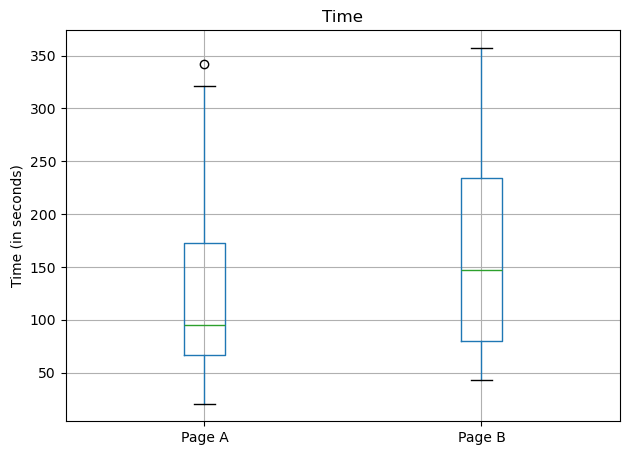

In [15]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In _Python_, we filter the `pandas` data frame first by page and then determine the mean of the `Time` column:

In [17]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a

35.66666666666667

To apply a permutation test, we need a function to randomly assign the 36 session times to a group of 21 (page A) and a group of 15 (page B). The _Python_ version of this permutation test is the following:

In [19]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean()-x.loc[list(idx_A)].mean()

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
perm_fun(session_times.Time, nA, nB)

8.35238095238094

This function works by sampling (without replacement) nB indices and assigning them to the B group; the remaining nA indices are assigned to group A. The difference between the two means is returned. Calling this function R = 1,000 times and specifying nA = 21 and nB = 15 leads to a distribution of differences in the session times that can be plotted as a histogram. In _Python_, we can create a similar graph using `matplotlib`: 

Text(0, 0.5, 'Frequency')

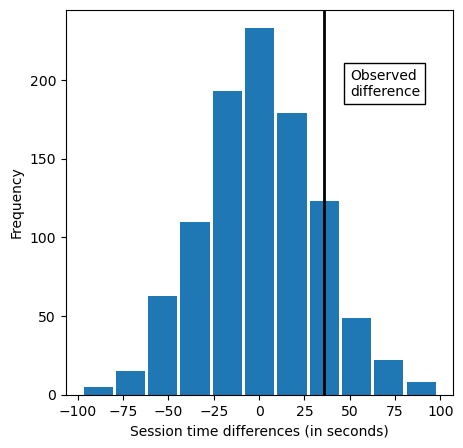

In [21]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range (1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x=mean_b - mean_a, color = 'black', lw=2)
ax.text(50,190, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

The histogram, in Figure 3-4 shows that mean difference of random permutations often exceeds the observed difference in session times (the vertical line). As the simulation uses random numbers, the percentage will vary. For example, in the _Python_ version, we got 14.1%:

In [23]:
np.mean(perm_diffs > (mean_b - mean_a))

0.13

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.

## Statistical Significance and p-Values

### Key Terms
_`p-value`_ - Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.

_`Alpha`_ - The probability threshold of "unusualness" that chance results must surpass for actual outcomes to be deemed statistically significant.

_`Type 1 error`_ - Mistakenly concluding an effect is due to real (when it is chance)

_`Type 2 error`_ - Mistakenly concluding an effect is due to chance (when it is real)

Reusing the function perm_fun defined in “Example: Web Stickiness” on page 98, we can create a histogram of randomly permuted differences in conversion rate in _Python_:

Observed difference: 0.0368%


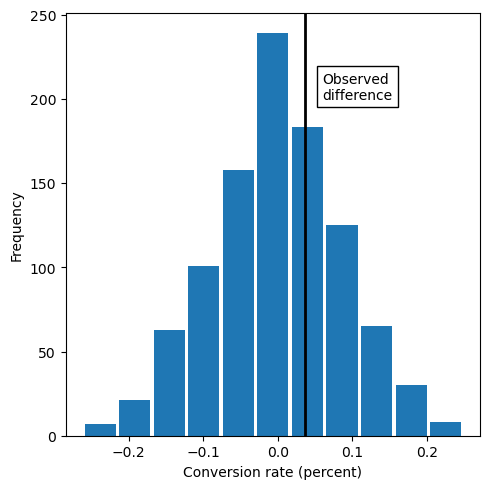

In [26]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## p-Values

We can estimate a p-value from our permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference.

The method `scipy.stats.chi2_contingency` takes the values.

In [28]:
survivors = np.array([[200,23739-200], [182,22588-182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


## t-Tests

A very common one is the t-test, named after Student’s t-distribution, originally developed by W. S. Gosset _to approximate the distribution of a single sample mean_.

### Key Terms
`Test statistic` - A metric for the difference or effect of interest.

`t-statistic` - A standardized version of common test statistics such as means.

`t-distribution` - A reference distribution (in this case derived from the null hypothesis), to which the observed t-statistic can be compared.

A classic statistics text would at this stage show various formulas that incorporate Gosset’s distribution and demonstrate how to standardize your data to compare it to the standard t-distribution. These formulas are not shown here because all statistical software, as well as _R_ and _Python_, includes commands that embody the formula.

The function `scipy.stats.ttest_ind` can be used in _Python_:

In [32]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                     session_times[session_times.Page == 'Page B'].Time,
                     equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


# ANOVA

Suppose that, instead of an A/B test, we had a comparison of multiple groups, say A/B/C/D, each with numeric data. The statistical procedure that tests for a statistically significant difference among the groups is called _analysis of variance_, or _ANOVA_.

### Key Terms
`Pairwise comparison` - A hypothesis test (e.g., of means) between two groups among multiple groups.

`Omnibus test` - A single hypothesis test of the overall variance among multiple group means.

`Decomposition of variance` - Separation of components contributing to an individual value (e.g., from the overall average, from a treatment mean, and from a residual error).

`F-statistic` - A standardized statistic that measures the extend to which differences among group means excedd what might be expected in a chance model.

`SS` - _"Sum of squares"_, referring to deviations from some average value.

### Key Ideas
- ANOVA is a statistical procedure for _analyzing the results_ of an experiment with _multiple groups_.
- It is the _extension_ of similar procedures for the _A/B test_, used to assess whether the overall variation among groups is within the range of chance variation.
- A _useful outcome_ of ANOVA is the _identification of variance components_ associated with group _treatments_, _interaction effects_, and _errors_.

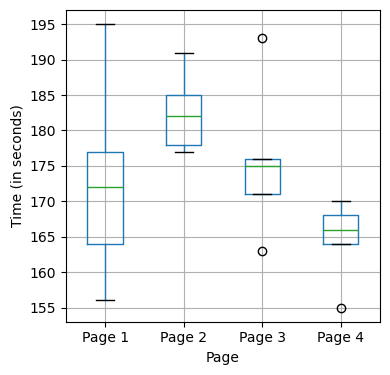

In [35]:
four_sessions = pd.read_csv(r"E:\Personal\Full_Stack_Data_Analyst\Data_Science\O'Reilly Books\practical-statistics-for-data-scientists-master\practical-statistics-for-data-scientists-master\data\four_sessions.csv")

ax = four_sessions.boxplot(by='Page', column='Time', figsize=(4,4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [36]:
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In _Python_, we can compute the permutation test using the following code:

In [38]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
18.06666666666659


C:\Users\User\AppData\Local\Temp\ipykernel_26572\2694393218.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed_variance = four_sessions.groupby('Page').mean().var()[0]
C:\Users\User\AppData\Local\Temp\ipykernel_26572\2694393218.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.groupby('Page').mean().var()[0]


## F-Statistic

This is a statistical test for ANOVA for _comparing the mean of two groups._ It is based on the _ratio of the variance_ across group means to the variance due to residual error. The _higher this ratio_, the _more_ statistically _significant_ the result. If the data follows a normal distribution, then statistical theory dictates that the statistic should have a certain distribution. Based on this, it is possible to compute _p-value_.

The `statsmodels` package provided as ANOVA implementation in _Python:_

In [58]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table=sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


`Df` - degrees of freedom
`Sum Sq` is "sum of squares"
`Mean Sq` - mean squares (short for mean-squared deviations)
`F value` is the "F statistic"

`Grand average`
- _sum of squares_ is the departure of the grand average from 0, squared, times 20 (the number of observations)
- _df_ is 1, by definition

`Treatment means`
 - the degrees of freedom is 3
 - _sum of squares_ is the sum of squared departures between the treatment means and the grand average

`Residuals`
- _df_ is 20 (all observations can vary)
- _SS_ sum of squared difference between the individual observations and the treatment means
- _Mean squares (MS)_ - the sum of squares divided by the degrees of freedom

`F-Statistic` - F value depends only on this ratio and can be compared to standard F-distribution to determine the difference among treatment means are greater than would be expected in random chance variation
- MS(treatment)/MS(error)

### Decomposition of Variance

Breaking down the observed data value within a data set into - grand average, the treatment effect, and the residual error.

`Steps`
1. Start with grand average (173.75 for web page stickiness data).
2. Add treatment effect, which might be negative (independent variable = web page)
3. Add residual error, which might be negative.

_Example:_
1. Start with grand average: 173.75.
2. Add treatment (group) effect: –1.75 (172 – 173.75).
3. Add residual: –8 (164 – 172).
4. Equals: 164.

## Two-Way ANOVA

The _one way_ ANOVA only have _one_ factor, while `two-way` ANOVA a second factor is involved - "weekend versus weekday". For example, group A weekend, group A weekday, group B weekend, etc. Like one-way ANOVA, we can handle it by identifying the _interaction effect._ After identifying the grand average effect and the treatment effect, we then _separate_ the weekend and weekday observations for each group and find the difference between the averages for those subsets and the treatment average.

ANOVA and then two-way ANOVA are the `first steps on the road toward a full statistical model,` such as _regression_ and _logistic regression_, in which multiple factors and their effects can be modeled.